# Deep Q-Network implementation.

This homework shamelessly demands you to implement DQN — an approximate Q-learning algorithm with experience replay and target networks — and see if it works any better this way.

**Papers:**

[1] Original paper, 2013: https://arxiv.org/pdf/1312.5602.pdf

[2] Extended paper, Nature, 2015: https://web.stanford.edu/class/psych209/Readings/MnihEtAlHassibis15NatureControlDeepRL.pdf

[3] Rainbow, 2017: https://arxiv.org/pdf/1710.02298.pdf

**This notebook is the main homework notebook.**
Another notebook is given for debug: (**homework_pytorch_debug**). The debug notebook is not supported anymore, the codes have diverged. However, it can be useful in some cases. The tasks are similar and they used to share most of the code. The main difference is in environments. In main notebook it can take some 2 hours for the agent to start improving so it seems reasonable to launch the algorithm on a simpler env first. In debug one it is CartPole and it will train in several minutes.

**About evaluation:** All points are only given for the main notebook.

**Plan and evaluation points:**
1. Getting to know the environment: most of the code is implemented for you
2. DQN as it is (10 points): the main part of DQN implementation
3. Main Loop (3 points): the training loop itself. Please, note, it can be really time-consuming, and implementation bugs can arise.
4. Interpretation (2 points): calculation of episode statistics and their interpretation

In [20]:
import os
import sys

if "google.colab" in sys.modules and not os.path.exists(".setup_complete"):
    os.makedirs("dqn", exist_ok=True)
    os.makedirs("test_td_loss", exist_ok=True)

    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash

    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week04_approx_rl/dqn/atari_wrappers.py -P dqn/
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week04_approx_rl/dqn/utils.py -P dqn/
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week04_approx_rl/dqn/replay_buffer.py -P dqn/
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week04_approx_rl/dqn/framebuffer.py -P dqn/
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week04_approx_rl/dqn/analysis.py -P dqn/
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week04_approx_rl/dqn/logger.py -P dqn/
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week04_approx_rl/test_td_loss/compute_td_loss.py -P test_td_loss/
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week04_approx_rl/requirements.txt

    !pip install -r requirements.txt

    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ["DISPLAY"] = ":1"

__Frameworks__ - we'll accept this homework in any deep learning framework. This particular notebook was designed for PyTorch, but you find it easy to adapt it to almost any Python-based deep learning framework.

In [21]:
%matplotlib inline
import ale_py
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np

### Let's play some old videogames
![img](https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/nerd.png)

This time we're gonna apply approximate Q-learning to an Atari game called Breakout. It's not the hardest thing out there, but it's definitely way more complex than anything we have tried before.

**These are various versions of Breakout provided by Gynmasium:**

In [22]:
gym.register_envs(ale_py)

all_names = list(gym.envs.registry.keys())
names_breakout = [name for name in all_names if "Break" in name]
names_breakout

['Breakout-v0',
 'BreakoutDeterministic-v0',
 'BreakoutNoFrameskip-v0',
 'Breakout-v4',
 'BreakoutDeterministic-v4',
 'BreakoutNoFrameskip-v4',
 'Breakout-ram-v0',
 'Breakout-ramDeterministic-v0',
 'Breakout-ramNoFrameskip-v0',
 'Breakout-ram-v4',
 'Breakout-ramDeterministic-v4',
 'Breakout-ramNoFrameskip-v4',
 'ALE/Breakout-v5']

In [23]:
# ENV_NAME = "BreakoutDeterministic-v4"  # this one is simpler
ENV_NAME = "ALE/Breakout-v5"

If you are curious about Atari environments in Gymnasium, please, refer to:
- [4] Gymnasium docs: https://gymnasium.farama.org/environments/atari/
- [5] Longer paper: https://arxiv.org/abs/1709.06009
- [6] Shorter paper: https://www.ijcai.org/Proceedings/2018/0787.pdf

For now it's enough to know about the v5 environments:
- v5 environments are recommended for use
- frame_skip=5, every 5-th frame is shown to the agent and the chosen action is executed for the next 5 moves
- randomness comes from repeat_action_probability=0.25: with this probability the previous action is executed instead of the chosen action

## Getting to know the Environment

**Let's see what observations look like.**

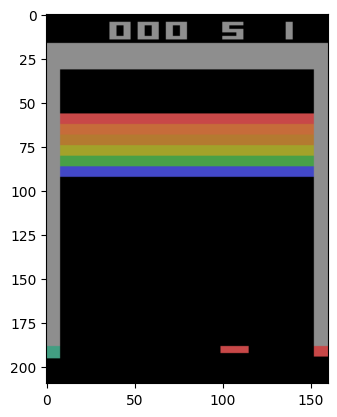

In [24]:
env = gym.make(ENV_NAME, render_mode="rgb_array")
env.reset()
plt.imshow(env.render())
plt.show()

**Some more observations, coming from taking random actions**

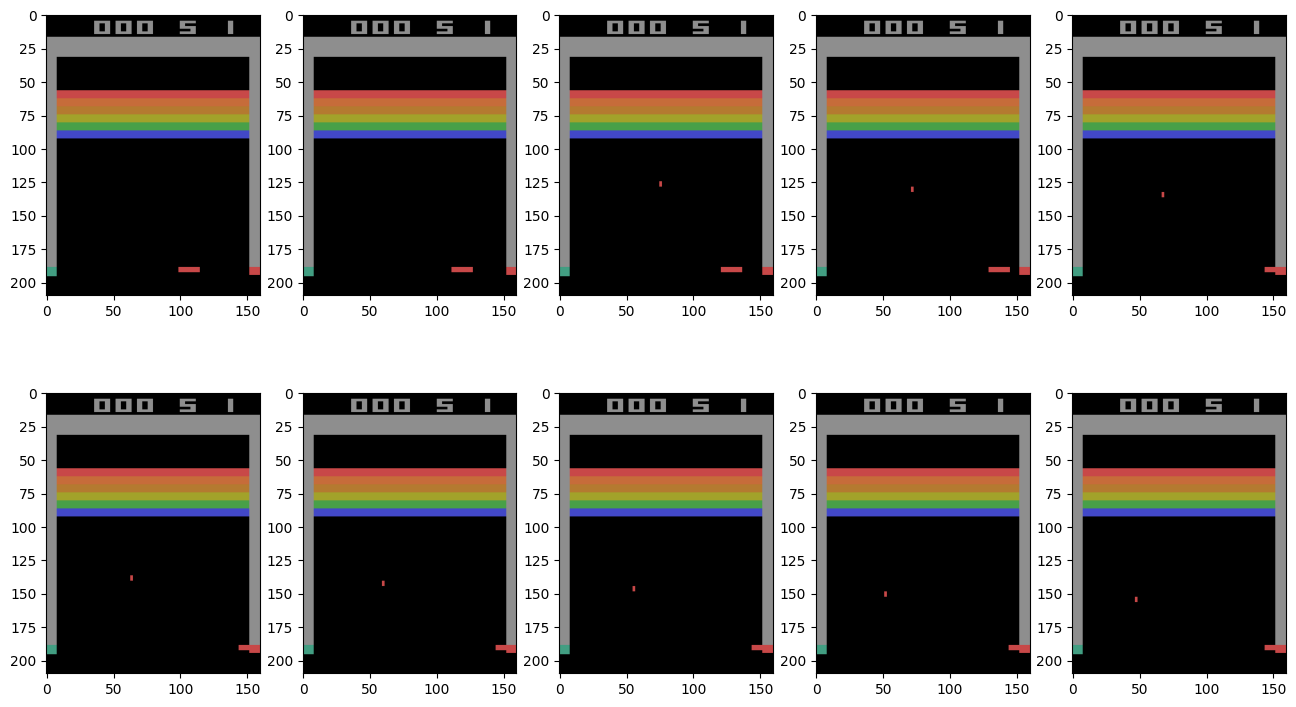

In [25]:
env = gym.make(ENV_NAME, render_mode="rgb_array")
env.reset()

n_cols = 5
n_rows = 2
fig = plt.figure(figsize=(16, 9))

for row in range(n_rows):
    for col in range(n_cols):
        ax = fig.add_subplot(n_rows, n_cols, row * n_cols + col + 1)
        ax.imshow(env.render())
        env.step(env.action_space.sample())

plt.show()

**About the game:** You have 5 lives and get points for breaking the wall. Higher bricks cost more than the lower ones. There are 4 actions: start game (should be called at the beginning and after each life is lost), move left, move right and do nothing. There are some common wrappers used for Atari environments.

**Let's take a look at action meanings:**

In [26]:
env.unwrapped.get_action_meanings()

['NOOP', 'FIRE', 'RIGHT', 'LEFT']

1. NOOP stands for the action of doing nothing
2. Right and Left move the platform to the corresponding direction
3. Fire releases the ball in the beginning of a life

In this assignment we will wrap the environment to execute the "Fire" action in the beginning of a life automatically. It will turn the "FIRE" action into another "NOOP".  
Also, we will wrap the environment to make an episode last for 1 life instead of 5 ones.  
These transforms are claimed as non-recommended in the paper [5] but it was done in the original paper [1] and it will help the training to converge faster.

**Let's play a little.**

Pay attention to zoom and fps args of play function. Control: A, D, space.

In [ ]:
# # Does not work in Colab.
# Even on a local laptop breaks matplotlib rendering. So it's recommended to restart the notebook after playing.
# # Use the Escape button to continue.

# from gymnasium.utils.play import play

# play(env=gym.make(ENV_NAME, render_mode="rgb_array"), zoom=4, fps=10)

## Wrapping the Environment

In [ ]:
def make_basic_env():
    return gym.make(ENV_NAME, render_mode="rgb_array")

### Processing game image

Let's check the shape and the dtype of the observation:

In [ ]:
env = make_basic_env()
obs, *_ = env.reset()
obs.shape, obs.dtype

Raw Atari images are large, 210x160x3 by default. However, we don't need that level of detail in order to learn from them.

We can thus save a lot of time by preprocessing game image, including
* Resizing to a smaller shape, 64x64 (or 84 x 84, which is used in literature)
* Converting to grayscale
* Cropping irrelevant image parts (top, bottom and edges) \[we won't do this\]

The images are of the uint8 dtype.  
uint8 stands for the 8-bit unsigned integer type.  
We are going to store 10^5 or 10^6 observations in memory (RAM), so let's pay attention to preserving the 8-bit type after our transforms.

In [ ]:
def apply_gray_scale_wrap(env):
    # With the argument values chosen as below, the gym.wrappers.AtariPreprocessing wrapper
    # only converts images to grayscale and downsamples them the screen_size
    env = gym.wrappers.AtariPreprocessing(
        env,
        noop_max=0,  # the default value 30 can be harmful with FireResetEnv and frame_skip=5
        frame_skip=1,  # frame_skip has already been set to 5 inside the env
        terminal_on_life_loss=False,  # we do this explicitly in the FireResetEnv wrapper
        screen_size=84,  # please use 84 (which is the standard value) or 64 (which will save some computations and memory)
    )
    return env


env = make_basic_env()
env = apply_gray_scale_wrap(env)

obs, *_ = env.reset()

assert obs.dtype == np.dtype("uint8"), obs_dtype

print(obs.shape, obs.dtype)
plt.imshow(obs)
plt.show()

### Atari specific wrappers

We try to make our lives a little easier with the following wrappers:
1. EpisodicLifeEnv it makes the signal that dropping a ball is not good more explicit
2. Using FireResetEnv: with it the agent doesn't have to perform a special action to fire the ball in the beginning of a life

In [ ]:
from dqn.atari_wrappers import EpisodicLifeEnv, FireResetEnv


def apply_atary_specific_wrap(env):
    env = EpisodicLifeEnv(env)
    env = FireResetEnv(env)
    return env


env = make_basic_env()
env = apply_gray_scale_wrap(env)
env = apply_atary_specific_wrap(env)

obs, *_ = env.reset()

print(obs.shape, obs.dtype)
plt.imshow(obs)
plt.show()

### FrameStack
To make the game playable from a single observation (note the direction of the ball), we stack 4 consecutive frames:

In [ ]:
N_FRAMES_STACKED = 4

def make_final_env(apply_frame_stack=True):
    """
    Builds the environment with all the wrappers applied.
    The environment is meant be used directly as an RL algorithm input.

    apply_frame_stack=False can be useful for vecotrized environments, which are not required for this assignment.
    """
    env = make_basic_env()
    env = apply_gray_scale_wrap(env)
    env = apply_atary_specific_wrap(env)
    if apply_frame_stack:
        env = # your code. Please, use gym.wrappers.FrameStack
    return env


env = make_final_env()

obs, *_ = env.reset()
print(f"Shape: {obs.shape}, dtype: {obs.dtype}, Python object type: {type(obs)}")
for _ in range(N_FRAMES_STACKED - 1):
    obs, *_ = env.step(env.action_space.sample())
print()


print("Frames, left to right: from older to more recent. The ball is dropping.")
_, axes = plt.subplots(figsize=(len(obs) * 3, 4), ncols=len(obs))
for ax, frame in zip(axes, obs):
    ax.imshow(frame)
plt.show()

**That is the final version of the environment we are going to do RL on.**

**Let's discuss the representation of an obsevation.**\
An observation is a 4-frame-stack of grayscale images with reduced resolution.\
Memory (RAM) is a high-demand resource in this task. That's why:
1. We use the uint8 dtype instead of float32 the neural network will operate on
2. We don't represent them as numpy.ndarrays. **LazyFrames** are used by gym.wrappers.FrameStack instead. 2 consecutive observations share 3 of 4 frames. LazyFrames make use of this fact to save memory.
When we feed the observations to neural networks, we should remember to scale them to the \[-1, 1\] range. We'll implement scaling as the first layer of a neural network, but that'll be later.

**The ball is dropping, but its hard to notice. Let's define a function to render more human-readable images:**

In [ ]:
def merge_frame_stack_to_plot(frame_stack_obs: np.ndarray | gym.wrappers.frame_stack.LazyFrames):
    """
    A helper function to plot a frame stack as a single human-interpretable image.

    Brighter pixels are more recent, pale pixels are older.
    Motions goes from pale to bright.

    Note! This function is designed for human vision convenience and it is NOT supposed to be used as part of
    data preprocessing for the Reinforcement Learning agent.
    """
    weights = np.ones(frame_stack_obs.shape[0], dtype=float)
    weights[-1] += weights.sum()
    weights /= weights.sum()
    result = (weights[:, None, None] * frame_stack_obs).sum(0)
    return result


obs_joint = merge_frame_stack_to_plot(obs)
plt.imshow(obs_joint)
plt.show()

Hope that's better

In [ ]:
N_ACTIONS = env.action_space.n
STATE_SHAPE = env.observation_space.shape

**Let's see if the game is still playable after applying the wrappers.**
At playing the EpisodicLifeEnv wrapper seems not to work but actually it does (because after when life finishes a new ball is dropped automatically - it means that FireResetEnv wrapper understands that a new episode began).

**Not supported for now.**

## DQN as it is (10 pts)

### Building a network

We now need to build a neural network that can map images to state q-values. This network will be called on every agent's step so it better not be resnet-152 unless you have an array of GPUs. Instead, you can use strided convolutions with a small number of features to save time and memory.

You can build any architecture you want, but you can find a couple of examples on diagrams below.

**Dueling network:**\
Paper: https://arxiv.org/pdf/1511.06581.pdf
$$Q_{\theta}(s, a) = V_{\eta}(f_{\xi}(s)) + A_{\psi}(f_{\xi}(s), a) - \frac{\sum_{a'}A_{\psi}(f_{\xi}(s), a')}{N_{actions}},$$
where $\xi$, $\eta$, and $\psi$ are, respectively, the parameters of the
shared encoder $f_ξ$ , of the value stream $V_\eta$ , and of the advantage stream $A_\psi$; and $\theta = \{\xi, \eta, \psi\}$ is their concatenation.

This is what it looks like:

Simple, expects height=width=64

<img src="https://github.com/girafe-ai/ml-course/blob/24s_advanced/assignments/lab05_dqn/img/dueling_basic.png?raw=1" alt="dueling_basic" width="500"/>

Nature DQN ([2]), expects height=width=84

<img src="https://github.com/girafe-ai/ml-course/blob/24s_advanced/assignments/lab05_dqn/img/dueling_nature.png?raw=1" alt="dueling_nature" width="500"/>

In [ ]:
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

These constants will be useful

In [ ]:
N_ACTIONS, N_FRAMES_STACKED

In [ ]:
class ConvBackbone(nn.Sequential):
    """
    The convolutional part of a DQN model.
    Please, don't think about input scaling here: it will be implemented below.
    """
    def __init__(self, c_in: int = N_FRAMES_STACKED) -> None:
        super().__init__(
            nn.Conv2d(...),
            ...
            # your code,
            nn.Flatten(),
        )


class DuelingDqnHead(nn.Module):
    """
    Implenets the Dueling DQN logic.
    Please, don't think about gradient scaling here (if you know what it is about): it will be implemented below.
    """
    def __init__(self, n_actions, inp_size=64 * 7 * 7, hidden_size=512) -> None:
        super().__init__()
        self.adv_stream = nn.Sequential(
            # your code
        )
        self.value_stream = nn.Sequential(
            # your code
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        assert x.ndim == 2, x.shape  # (batch_size, n_features)
        # your code
        # When calculating the mean advantage, please, remember, x is a batched input!

Let's make a simple test for the network architecture:

In [ ]:
@torch.no_grad()
def test_network_part_shapes(backbone, head):
    batch_size = 3
    env = make_final_env()
    s, _ = env.reset()
    inp = torch.rand(batch_size, *s.shape)

    features = backbone(inp)
    qvalues = head(features)

    assert features.ndim == 2, features.shape
    assert features.shape[0] == batch_size, features.shape

    assert qvalues.ndim == 2, qvalues.shape
    assert qvalues.shape[0] == batch_size, qvalues.shape
    assert qvalues.shape[1] == N_ACTIONS, qvalues.shape

    print("Test passed!")


test_network_part_shapes(
    backbone=ConvBackbone(N_FRAMES_STACKED),
    head=DuelingDqnHead(N_ACTIONS),
)

**Now let's build a full model.**

In [ ]:
MAX_UINT_8 = 2**8 - 1


class InputScaler(nn.Module):
    def __init__(self, mult=1 / MAX_UINT_8):
        super().__init__()
        self.mult = mult

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x * self.mult


class GradScalerFunctional(torch.autograd.Function):
    """
    A torch.autograd.Function works as Identity on forward pass
    and scales the gradient by scale_factor on backward pass.
    """

    @staticmethod
    def forward(ctx, input, scale_factor):
        ctx.scale_factor = scale_factor
        return input

    @staticmethod
    def backward(ctx, grad_output):
        scale_factor = ctx.scale_factor
        grad_input = grad_output * scale_factor
        return grad_input, None


class GradScaler(nn.Module):
    """
    An nn.Module incapsulating GradScalerFunctional
    """

    def __init__(self, scale_factor: float):
        super().__init__()
        self.scale_factor = scale_factor

    def forward(self, x):
        return GradScalerFunctional.apply(x, self.scale_factor)


class DQNetworkDueling(nn.Sequential):
    def __init__(self, c_in: int, n_actions: int) -> None:
        input_scaler = InputScaler()  # the inputs come from the uint8 range
        backbone = ConvBackbone(c_in=c_in)  # your code
        grad_scaler = GradScaler(1 / 2**0.5)  # Dueling DQN suggests do scale the gradient by 1 / sqrt(2)
        head = DuelingDqnHead(n_actions=n_actions)
        super().__init__(input_scaler, backbone, grad_scaler, head)

In [ ]:
@torch.no_grad()
def test_network_shapes(model):
    batch_size = 3
    env = make_final_env()
    s, _ = env.reset()
    inp = torch.rand(batch_size, *s.shape)

    qvalues = model(inp)

    assert qvalues.ndim == 2, qvalues.shape
    assert qvalues.shape[0] == batch_size, qvalues.shape
    assert qvalues.shape[1] == N_ACTIONS, qvalues.shape

    print("Test passed!")


test_network_shapes(model=DQNetworkDueling(N_FRAMES_STACKED, N_ACTIONS))

**Now let's wrap our model into an Agent class.**  
It will implement epsilon-greedy policy on numpy ndarrays.

In [ ]:
class DQNAgent(nn.Module):
    """
    Epsilon-greedy policy with a torch.nn.Module Q-value estimator.
    """

    def __init__(self, q_network: nn.Module, epsilon=1) -> None:
        super().__init__()
        self.epsilon = epsilon
        self.q_network = q_network

    def forward(self, state_t):
        """
        takes agent's observation (tensor), returns qvalues (tensor)
        :param state_t: a batch of 4-frame buffers, shape = [batch_size, 4, h, w]
        """
        # Use your network to compute qvalues for given state
        qvalues =  # your code
        return qvalues

    @torch.no_grad()  # we don't need autograd here, so let's save the computations
    def get_qvalues(self, states: np.ndarray) -> np.ndarray:
        """
        like forward, but works on numpy arrays, not tensors
        """
        model_device = next(self.parameters()).device
        states_pt = torch.tensor(
            np.array(states), device=model_device, dtype=torch.float32
        )
        # Use your network to compute qvalues for given state
        qvalues_pt = # your code
        qvalues = qvalues_pt.data.cpu().numpy()
        return qvalues

    def sample_actions_by_qvalues(self, qvalues: np.ndarray, greedy: bool = False) -> np.ndarray:
        """pick actions given qvalues. Uses epsilon-greedy exploration strategy."""
        batch_size, n_actions = qvalues.shape
        # greedy_actions =  # your code
        greedy_actions = qvalues.argmax(axis=-1)  # your code
        if greedy:
            return greedy_actions

        random_actions = np.random.randint("your code")
        should_explore = np.random.binomial("your code")
        epsilon_greedy_actions = np.where(
            "your code"
        )
        return epsilon_greedy_actions

    def sample_actions(self, states: np.ndarray) -> np.ndarray:
        qvalues = self.get_qvalues(states)
        actions = self.sample_actions_by_qvalues(qvalues)
        return actions

In [ ]:
test_network_shapes(model=DQNAgent(DQNetworkDueling(N_FRAMES_STACKED, N_ACTIONS)))

In [ ]:
agent = DQNAgent(DQNetworkDueling(N_FRAMES_STACKED, N_ACTIONS), epsilon=0.5).to(device)

Now let's try out our agent to see if it raises any errors.

In [ ]:
def evaluate(env, agent, n_games=1, greedy=False, t_max=10000, seed=None):
    """Plays n_games full games. If greedy, picks actions as argmax(qvalues). Returns mean reward."""
    rewards = []
    for _ in range(n_games):
        s, _ = env.reset(seed=seed)
        reward = 0
        for _ in range(t_max):
            action = agent.sample_actions(np.array(s)[None], greedy=greedy)[0]
            s, r, terminated, truncated, _ = env.step(action)
            reward += r
            if terminated or truncated:
                break

        rewards.append(reward)
    return np.mean(rewards)


print(evaluate(env, agent, n_games=1, greedy=False))
print(evaluate(env, agent, n_games=1, greedy=True))

### Experience replay
For this assignment, we provide you with experience replay buffer.

<img src="https://github.com/girafe-ai/ml-course/blob/24s_advanced/assignments/lab05_dqn/img/exp_replay.png?raw=1" alt="exp_replay" width="500"/>
<!-- ![img](https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/exp_replay.png) -->

#### The interface is fairly simple:
* `exp_replay.add(obs, act, rw, next_obs, done)` - saves (s,a,r,s',done) tuple into the buffer
* `exp_replay.sample(batch_size)` - returns observations, actions, rewards, next_observations and is_done for `batch_size` random samples.
* `len(exp_replay)` - returns number of elements stored in replay buffer.

In [ ]:
from dqn.replay_buffer import ReplayBuffer

exp_replay = ReplayBuffer(10)

for _ in range(30):
    exp_replay.add(env.reset()[0], env.action_space.sample(), 1.0, env.reset()[0], done=False)

obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(5)

assert len(exp_replay) == 10, "experience replay size should be 10 because that's what maximum capacity is"

**The `play_and_record` function, defined below is the main way the agent will interact with the environment during training.**

Previously we used to train RL algorithms on entire episodes.  

This time we keep the environment constantly running and will be getting small portions of interactions with it.

The agent takes several actions (4 actions in [2] and [3]), the corresponding (s, a, r, s', terminated) tuples are put into the replay buffer.  
Whenever an episode finishes (i.e. `truncated or terminated`), the environment is reset and the procedure continues as usually.  

To make the first step in a constantly running environment, the agent needs to know the state of the environment. This is the meaning of the `initial_state` argument of the function.

It's worth noting, the agent does not train on the fresh tuples immediately. The agent trains on samples which are sampled from the buffer.

**Implementation note:**
We define an `ActionSampler` protocol. The goal of it is to let the function `play_and_record` accept not only `DQNAgent` class instances, but any object that can sample actions.

In [ ]:
from typing import Protocol


class ActionSampler(Protocol):
    """
    A protocol which defines an Callable which samples actions from states
    """
    def __call__(self, state: gym.wrappers.frame_stack.LazyFrames) -> int: ...


class RandomActionSampler:
    """
    We will need this guy to fill the buffer with initial 50-200K observations from a random policy.
    """

    def __init__(self, action_space) -> None:
        self.action_space = action_space

    def __call__(self, state: gym.wrappers.frame_stack.LazyFrames) -> int:
        action = self.action_space.sample()
        return action


class DqnActionSampler:
    """
    DQNAgent works on batched np.ndarray inputs.
    This class uses a DQNAgent to sample actions from single LazyFrames observations.

    This will be an epsilon-greedy sampler.
    A greedy sampler can be defined as well, but we won't need it.
    """
    def __init__(self, agent: DQNAgent):
        self.agent = agent

    def __call__(self, state: gym.wrappers.frame_stack.LazyFrames) -> int:
        state_batched = np.array(state)[None]
        action_batched = # your code
        action = action_batched.item()
        return action


@torch.no_grad()
def play_and_record(initial_state: gym.wrappers.frame_stack.LazyFrames, action_sampler: ActionSampler, env, exp_replay, n_steps=1):
    """
    Play the game for exactly n_steps, record every (s,a,r,s', done) to replay buffer.
    Whenever game ends due to termination or truncation, add record with done=terminated and reset the game.
    It is guaranteed that env has terminated=False when passed to this function.

    PLEASE DO NOT RESET ENV UNLESS IT IS "DONE"

    :returns: return sum of rewards over time and the state in which the env stays
    """
    s = initial_state
    sum_rewards = 0

    # Play the game for n_steps as per instructions above
    <YOUR CODE>

    return sum_rewards, s

In [ ]:
def test_play_and_record(action_sampler):
    exp_replay = ReplayBuffer(10_000)

    state, _ = env.reset()

    # action_sampler = RandomActionSampler(env.action_space)
    # action_sampler = DqnActionSampler(agent)
    play_and_record(state, action_sampler, env, exp_replay, n_steps=1000)

    # if you're using your own experience replay buffer, some of those tests may need correction.
    # just make sure you know what your code does
    assert (
        len(exp_replay) == 1000
    ), "play_and_record should have added exactly 1000 steps, " "but instead added %i" % len(exp_replay)
    is_dones = list(zip(*exp_replay._storage))[-1]

    assert 0 < np.mean(is_dones) < 0.1, (
        "Please make sure you restart the game whenever it is 'done' and "
        "record the is_done correctly into the buffer. Got %f is_done rate over "
        "%i steps. [If you think it's your tough luck, just re-run the test]" % (np.mean(is_dones), len(exp_replay))
    )

    for _ in range(100):
        obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(10)
        assert obs_batch.shape == next_obs_batch.shape == (10,) + STATE_SHAPE
        assert act_batch.shape == (10,), "actions batch should have shape (10,) but is instead %s" % str(
            act_batch.shape
        )
        assert reward_batch.shape == (10,), "rewards batch should have shape (10,) but is instead %s" % str(
            reward_batch.shape
        )
        assert is_done_batch.shape == (10,), "is_done batch should have shape (10,) but is instead %s" % str(
            is_done_batch.shape
        )
        assert [int(i) in (0, 1) for i in is_dones], "is_done should be strictly True or False"
        assert [0 <= a < N_ACTIONS for a in act_batch], "actions should be within [0, n_actions)"

    print("Well done!")


print("Random:")
test_play_and_record(RandomActionSampler(env.action_space))
print("DQN:")
test_play_and_record(DqnActionSampler(agent))

### Target networks

We also employ the so called "target network" - a copy of neural network weights to be used for reference Q-values:

The network itself is an exact copy of agent network, but it's parameters are not trained. Instead, they are moved here from agent's actual network every so often.

$$ Q_{reference}(s,a) = r + \gamma \cdot \max _{a'} Q_{target}(s',a') $$

![img](https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/target_net.png)

In [ ]:
target_network = DQNetworkDueling(N_FRAMES_STACKED, N_ACTIONS).to(device)
target_network.load_state_dict(agent.q_network.state_dict())

### Learning with... Q-learning
Here we write a function similar to `agent.update` from tabular q-learning.

Compute Q-learning TD error:

$$ L = { 1 \over N} \sum_i [ Q_{\theta}(s,a) - Q_{reference}(s,a) ] ^2 $$

With Q-reference defined as

$$ Q_{reference}(s,a) = r(s,a) + \gamma \cdot max_{a'} Q_{target}(s', a') $$

Where
* $Q_{target}(s',a')$ denotes Q-value of next state and next action predicted by __target_network__
* $s, a, r, s'$ are current state, action, reward and next state respectively
* $\gamma$ is a discount factor defined two cells above.


__Note 1:__ there's an example input below. Feel free to experiment with it before you write the function.

__Note 2:__ compute_td_loss is a major source of of bugs in this homework. We tried to cover it with tests, but if reward doesn't improve, it often helps to go through it line by line [with a rubber duck](https://rubberduckdebugging.com/).

**Double DQN**

$$ Q_{reference}(s,a) = r(s, a) + \gamma \cdot
Q_{target}(s',argmax_{a'}Q_\theta(s', a')) $$

We will use Double DQN for training, but **we ask you to implement both** of the methods to experience the difference.

In [ ]:
def compute_td_loss_on_tensors(
    states: torch.Tensor,  # (batch_size, *state_shape)
    actions: torch.Tensor,  # (batch_size,)
    rewards: torch.Tensor,  # (batch_size,)
    next_states: torch.Tensor,  # (batch_size, *state_shape)
    is_done: torch.Tensor,  # (batch_size,), torch.bool
    agent: nn.Module,
    target_network: nn.Module,
    gamma: float = 0.99,
    check_shapes=False,
):
    predicted_qvalues = agent(states)  # shape: [batch_size, n_actions]
    assert is_done.dtype is torch.bool

    # compute q-values for all actions in next states
    with torch.no_grad():
        predicted_next_qvalues_target = # your code;  # shape: [batch_size, n_actions]

    # select q-values for chosen actions
    predicted_qvalues_for_actions = predicted_qvalues[
        range(len(actions)), actions
    ]  # shape: [batch_size]

    # compute V*(next_states) using predicted next q-values
    next_state_values =  # your code

    if check_shapes:
        assert (
            next_state_values.dim() == 1
            and next_state_values.shape[0] == states.shape[0]
        ), "must predict one value per state"
        assert not next_state_values.requires_grad

    # compute "target q-values" for loss - it's what's inside square parentheses in the above formula.
    # at the last state use the simplified formula: Q(s,a) = r(s,a) since s' doesn't exist
    target_qvalues_for_actions =  # your code

    # mean squared error loss to minimize
    loss = torch.mean((predicted_qvalues_for_actions - target_qvalues_for_actions) ** 2)

    if check_shapes:
        assert (
            predicted_next_qvalues_target.data.dim() == 2
        ), "make sure you predicted q-values for all actions in next state"
        assert (
            next_state_values.data.dim() == 1
        ), "make sure you computed V(s') as maximum over just the actions axis and not all axes"
        assert (
            target_qvalues_for_actions.data.dim() == 1
        ), "there's something wrong with target q-values, they must be a vector"

    return loss

In [ ]:
from tests.compute_td_loss import (test_compute_td_loss_vanilla)

test_compute_td_loss_vanilla(compute_td_loss_on_tensors)
print("Well done!")

In [ ]:
def compute_td_loss_on_tensors_double(
    states: torch.Tensor,  # (batch_size, *state_shape)
    actions: torch.Tensor,  # (batch_size,)
    rewards: torch.Tensor,  # (batch_size,)
    next_states: torch.Tensor,  # (batch_size, *state_shape)
    is_done: torch.Tensor,  # (batch_size,), torch.bool
    agent: nn.Module,
    target_network: nn.Module,
    gamma: float = 0.99,
    check_shapes=False,
):
    predicted_qvalues = agent(states)  # shape: [batch_size, n_actions]
    assert is_done.dtype is torch.bool

    # compute q-values for all actions in next states
    with torch.no_grad():
        predicted_next_qvalues_target = # your code;  # shape: [batch_size, n_actions]

    # select q-values for chosen actions
    predicted_qvalues_for_actions = predicted_qvalues[
        range(len(actions)), actions
    ]  # shape: [batch_size]

    # compute V*(next_states) using predicted next q-values
    next_state_values =  # your code

    if check_shapes:
        assert (
            next_state_values.dim() == 1
            and next_state_values.shape[0] == states.shape[0]
        ), "must predict one value per state"
        assert not next_state_values.requires_grad

    # compute "target q-values" for loss - it's what's inside square parentheses in the above formula.
    # at the last state use the simplified formula: Q(s,a) = r(s,a) since s' doesn't exist
    target_qvalues_for_actions =  # your code

    # mean squared error loss to minimize
    loss = torch.mean((predicted_qvalues_for_actions - target_qvalues_for_actions) ** 2)

    if check_shapes:
        assert (
            predicted_next_qvalues_target.data.dim() == 2
        ), "make sure you predicted q-values for all actions in next state"
        assert (
            next_state_values.data.dim() == 1
        ), "make sure you computed V(s') as maximum over just the actions axis and not all axes"
        assert (
            target_qvalues_for_actions.data.dim() == 1
        ), "there's something wrong with target q-values, they must be a vector"

    return loss

In [ ]:
from tests.compute_td_loss import test_compute_td_loss_double

test_compute_td_loss_double(compute_td_loss_on_tensors_double)
print("Well done!")

**The following function works on np.ndarrays: it converts its inputs to torch.Tensors and calls the torch-tensor function**

In [ ]:
def compute_td_loss(
    states,
    actions,
    rewards,
    next_states,
    is_done,
    agent,
    target_network,
    gamma=0.99,
    check_shapes=False,
    device=None,
    tensor_loss_evaluator=compute_td_loss_on_tensors_double,
):
    """Compute td loss using torch operations only. Use the formulae above."""

    if device is None:
        device = next(agent.parameters()).device
    states = torch.tensor(states, device=device, dtype=torch.float32)  # shape: [batch_size, *state_shape]
    actions = torch.tensor(actions, device=device, dtype=torch.int64)  # shape: [batch_size]
    rewards = torch.tensor(rewards, device=device, dtype=torch.float32)  # shape: [batch_size]
    # shape: [batch_size, *state_shape]
    next_states = torch.tensor(next_states, device=device, dtype=torch.float)
    is_done = torch.tensor(is_done, device=device, dtype=torch.bool)  # shape: [batch_size]

    return tensor_loss_evaluator(
        states=states,
        actions=actions,
        rewards=rewards,
        next_states=next_states,
        is_done=is_done,
        agent=agent,
        target_network=target_network,
        gamma=gamma,
        check_shapes=check_shapes,
    )

Sanity checks

In [ ]:
obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(10)

loss = compute_td_loss(
    obs_batch,
    act_batch,
    reward_batch,
    next_obs_batch,
    is_done_batch,
    agent,
    target_network,
    gamma=0.99,
    check_shapes=True,
)
loss.backward()

assert loss.requires_grad and tuple(loss.data.size()) == (), "you must return scalar loss - mean over batch"
assert np.any(
    next(agent.parameters()).grad.data.cpu().numpy() != 0
), "loss must be differentiable w.r.t. network weights"
assert np.all(next(target_network.parameters()).grad is None), "target network should not have grads"

## Main loop (3 pts)

**If deadline is tonight and it has not converged:** It is ok. Send the notebook today and when it converges send it again.
If the code is exactly the same points will not be discounted.

It's time to put everything together and see if it learns anything.

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.auto import trange

In [ ]:
import random

seed = # your code
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [ ]:
env = make_final_env()

state, _ = env.reset(seed=seed)

agent = DQNAgent(DQNetworkDueling(N_FRAMES_STACKED, N_ACTIONS), epsilon=1).to(device)
target_network = DQNetworkDueling(N_FRAMES_STACKED, N_ACTIONS).to(device)
target_network.load_state_dict(agent.q_network.state_dict())

action_sampler = DqnActionSampler(agent)
action_sampler_random = RandomActionSampler(env.action_space)

Buffer of size $10^4$ can probably pass the threshold for this assignment.

Larger sizes ($10^5$ and $10^6$ are common) can show a much higher score.

In [ ]:
from dqn.utils import is_enough_ram

REPLAY_BUFFER_SIZE = 10**6
# INITIAL_BUFFER_FILL = 50_000  # Nature DQN Extended Data Table 1
INITIAL_BUFFER_FILL = 200_000  # Rainbow without prioritization
_n_steps = 100

exp_replay = ReplayBuffer(REPLAY_BUFFER_SIZE)
for i in trange(INITIAL_BUFFER_FILL // _n_steps):
    if not is_enough_ram(min_available_gb=0.1):
        print(
            """
            Less than 100 Mb RAM available.
            Make sure the buffer size in not too huge.
            Also check, maybe other processes consume RAM heavily.
            """
        )
        break
    play_and_record(state, action_sampler_random, env, exp_replay, n_steps=_n_steps)
    if len(exp_replay) >= INITIAL_BUFFER_FILL:
        break
print(len(exp_replay))

In [ ]:
len(exp_replay)

In [ ]:
update_frequency = (
    4  # n_steps for play_and_record; Nature DQN Extended Data Table 1 + Rainbow Table 4: Additional hyper-parameters
)
batch_size = 32  # Nature DQN Extended Data Table 1 + Table 4: Additional hyper-parameters
total_steps = 10 * 10**6  # this can be long, feel free to stop the training when the target score is reached
decay_steps = 10**6  # Nature DQN Extended Data Table 1

opt = torch.optim.Adam(agent.parameters(), lr=6.25e-05, eps=1.4e-4)  # Rainbow

init_epsilon = 1  # Nature DQN
final_epsilon = 0.1  # Nature DQN

loss_freq = 100
refresh_target_network_freq = 10_000  # Nature DQN
eval_freq = 10_000

max_grad_norm = 10  # Dueling DQN

n_lives = 5

In [ ]:
step = 0

In [ ]:
import time


def wait_for_keyboard_interrupt():
    try:
        while True:
            time.sleep(1)
    except KeyboardInterrupt:
        pass

In [ ]:
from dqn.utils import is_enough_ram, linear_decay
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()

In [ ]:
%load_ext tensorboard
%tensorboard --logdir runs

In [ ]:
env = make_final_env()
state, _ = env.reset()
with trange(step, total_steps + 1) as progress_bar:
    for step in progress_bar:
        if not is_enough_ram():
            print("less that 100 Mb RAM available, freezing")
            print("make sure everything is ok and use KeyboardInterrupt to continue")
            wait_for_keyboard_interrupt()

        agent.epsilon = linear_decay(init_epsilon, final_epsilon, step, decay_steps)

        # play
        _, state = play_and_record(state, action_sampler, env, exp_replay, n_steps=update_frequency)

        # train
        s, a, r, s_next, done = exp_replay.sample(batch_size)
        # <YOUR CODE: sample batch_size of data from experience replay>

        loss = compute_td_loss(s, a, r, s_next, done, agent, target_network, device=device)

        loss.backward()
        grad_norm = nn.utils.clip_grad_norm_(agent.parameters(), max_grad_norm)
        opt.step()
        opt.zero_grad()

        if step % loss_freq == 0:
            writer.add_scalar("loss", loss.data.cpu().item(), step)
            writer.add_scalar("grad_norm", grad_norm.cpu().item(), step)

        if step % refresh_target_network_freq == 0:
            # Load agent weights into target_network
            target_network.load_state_dict(agent.q_network.state_dict())
            torch.save(agent.state_dict(), "last_state_dict.pt")

        if step % eval_freq == 0:
            mean_reward = evaluate(make_final_env(), agent, n_games=3 * n_lives, greedy=True, seed=step)
            writer.add_scalar("mean_reward_per_life", mean_reward, step)

            initial_state_q_values = agent.get_qvalues([make_final_env().reset(seed=step)[0]])
            writer.add_scalar("initial_state_v", np.max(initial_state_q_values).item(), step)

            clear_output(True)
            print("buffer size = %i, epsilon = %.5f" % (len(exp_replay), agent.epsilon))

In [ ]:
agent = DQNAgent(DQNetworkDueling(N_FRAMES_STACKED, N_ACTIONS), epsilon=1).to(device)
agent.load_state_dict(torch.load("last_state_dict.pt"))

Agent is evaluated for 1 life, not for a whole episode of 5 lives. Rewards in evaluation are also truncated. Cuz this is what environment the agent is learning in and in this way mean rewards per life can be compared with initial state value

**The goal is to get 15 points in the real env**. So 3 or better 4 points in the preprocessed one will probably be enough. You can interrupt learning then.

Final scoring is done on a whole episode with all 5 lives.

In [ ]:
final_score = evaluate(make_final_env(), agent, n_games=30, greedy=True, t_max=10 * 1000, seed=9)
print("final score:", final_score)
assert final_score >= 3, "not as cool as DQN can"
print("Cool!")

## How to interpret plots:

This aint no supervised learning so don't expect anything to improve monotonously.
* **TD loss** is the MSE between agent's current Q-values and target Q-values. It may slowly increase or decrease, it's ok. The "not ok" behavior includes going NaN or stayng at exactly zero before agent has perfect performance.
* **grad norm** just shows the intensivity of training. Not ok is growing to values of about 100 (or maybe even 50) though it depends on network architecture.
* **mean reward** is the expected sum of r(s,a) agent gets over the full game session. It will oscillate, but on average it should get higher over time (after a few thousand iterations...).
 * In basic q-learning implementation it takes about 40k steps to "warm up" agent before it starts to get better.
* **Initial state V** is the expected discounted reward for episode in the oppinion of the agent. It should behave more smoothly than **mean reward**. It should get higher over time but sometimes can experience drawdowns because of the agaent's overestimates.
* **buffer size** - this one is simple. It should go up and cap at max size.
* **epsilon** - agent's willingness to explore. If you see that agent's already at 0.01 epsilon before it's average reward is above 0 - it means you need to increase epsilon. Set it back to some 0.2 - 0.5 and decrease the pace at which it goes down.
* Smoothing of plots is done with a gaussian kernel

At first your agent will lose quickly. Then it will learn to suck less and at least hit the ball a few times before it loses. Finally it will learn to actually score points.

**Training will take time.** A lot of it actually. Probably you will not see any improvment during first **150k** time steps (note that by default in this notebook agent is evaluated every 5000 time steps).

But hey, long training time isn't _that_ bad:
![img](https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/training.png)

## About hyperparameters:

The task has something in common with supervised learning: loss is optimized through the buffer (instead of Train dataset). But the distribution of states and actions in the buffer **is not stationary** and depends on the policy it was generated by. It can even happen that the mean TD error across the buffer is very low but the performance is extremely poor (imagine the agent collecting data to the buffer always manages to avoid the ball).

* Total timesteps and training time: It seems to be so huge, but actually it is normal for RL.

* $\epsilon$ decay shedule was taken from the original paper and is like traditional for epsilon-greedy policies. At the beginning of the training the agent's greedy policy is poor so many random actions should be taken.

* Optimizer: In the original paper RMSProp was used (they did not have Adam in 2013) and it can work not worse than Adam. For us Adam was default and it worked.

* lr: $10^{-3}$ would probably be too huge

* target network update frequency: has something in common with learning rate. Too frequent updates can lead to divergence. Too rare can lead to slow leraning. For millions of total timesteps thousands of inner steps seem ok. One iteration of target network updating is an iteration of the (this time approximate) $\gamma$-compression that stands behind Q-learning. The more inner steps it makes the more accurate is the compression.

### Video

In [ ]:
# record sessions
from gymnasium.wrappers import RecordVideo

with (
    make_final_env() as env,
    RecordVideo(env=env, video_folder="./videos", episode_trigger=lambda episode_number: True) as env_monitor,
):
    sessions = [evaluate(env_monitor, agent, n_games=n_lives, greedy=True) for _ in range(10)]

In [ ]:
# Show video. This may not work in some setups. If it doesn't
# work for you, you can download the videos and view them locally.

from base64 import b64encode
from pathlib import Path

from IPython.display import HTML

video_paths = sorted([s for s in Path("videos").iterdir() if s.suffix == ".mp4"])
video_path = video_paths[-1]  # You can also try other indices

if "google.colab" in sys.modules:
    # https://stackoverflow.com/a/57378660/1214547
    with video_path.open("rb") as fp:
        mp4 = fp.read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
else:
    data_url = str(video_path)

HTML(
    """
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(
        data_url
    )
)

## Let's have a closer look at this. Interpretation (2 pts).

Let's play 5 episodes (note that the game has 5 lives) and log some stats:

In [ ]:
from dqn.analysis import play_and_log_episode

env = make_final_env()
stats = play_and_log_episode(env, agent)

print("Keys:", list(stats.keys()))
print("Shapes:")
for key in ["states", "qvalues", "actions", "rewards"]:
    print(f"{key}: {stats[key].shape}")
print("terminated:", stats["episode_finished"])

Let's plot rewards:

In [ ]:
plt.plot(stats["rewards"])
plt.grid()
plt.show()

Your task it to evaluate the following quantities from the logs:
1. Discounted returns: $G[t] = \sum_{t'=t}^T \gamma ^ {t' - t}r[t]$, where $T$ is the total time of an episode.
2. State Values estimated by the agent: $V_{agent}[t] = \max_{a}Q_{agent}(s[t], a)$.
3. Q-spread: $\Delta Q[t] = \max_{a}Q_{agent}(s[t], a) - \min_{a}Q_{agent}(s[t], a)$

Create a new env: `env = make_final_env()`, play for 5 episodes (a full game has 5 lives, so it will be 1 full game).  
Plot rewards and the evaluated quantites for each of them.  
Using the plots, can you find points where the ball hits the wall?  
Where the ball hits the platform?  
Probably, you won't need all the quantities for that, but it's still good to check the behavior of a model.

The `merge_frame_stack_to_plot` function may be useful.

In [ ]:
def get_discounted_returns(rewards: Reversible[float], gamma: float) -> list[float]:
    """
    Calculates G[t] for each t, given rewards and gamma.

    Tip: Iterate backwards through rewards and use the following relationship:
    G[t] = r[t] + gamma * G[t + 1]
    """
    returns_reverse: list[float] = []
    last_return: float = 0
    for r in reversed(rewards):
        # your code
    returns = list(reversed(returns_reverse))
    return returns

## Bonus I (2 pts). Get High Score!

Get mean reward per life:
1. $\geq 20$: +1 pt
2. $\geq 40$: +2 pts

## Bonus II (2+ pts). Apply modifications to DQN.

* [Prioritized experience replay](https://arxiv.org/abs/1511.05952) (2 pts, please check for effective open-source implementations)
* [Noisy Nets](https://arxiv.org/abs/1706.10295) (2 pts, please, pay attention to the exploration policy and whether epsilon-greedy policy is used)
* [distributional RL](https://arxiv.org/abs/1707.06887)(distributional and distributed stand for different things here) (3 pts)
* Other modifications (2+ pts depending on complexity)

## Bonus III (2 pts). Distributed RL.

https://gymnasium.farama.org/api/vector/#gymnasium.vector.AsyncVectorEnv